In [5]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.2
    Uninstalling pip-24.2:
      Successfully uninstalled pip-24.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install pandas numpy matplotlib seaborn statsmodels scikit-learn tensorflow plotly


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

## Loading and Cleaning Data

In [28]:
data_2018 = pd.read_csv("Price_2018.csv")
data_2019 = pd.read_csv("Price_2019.csv")
data_2020 = pd.read_csv("Price_2020.csv")
data_2021 = pd.read_csv("Price_2021.csv")
data_2022 = pd.read_csv("Price_2022.csv")
df = pd.concat([data_2018,data_2019,data_2020,data_2021,data_2022])

In [29]:
df.head(5)

,Unnamed: 0,0,1
0,0,01-01-2018,"₹ 2,676.94"
1,1,02-01-2018,"₹ 2,680.82"
2,2,03-01-2018,"₹ 2,679.15"
3,3,04-01-2018,"₹ 2,669.70"
4,4,05-01-2018,"₹ 2,686.88"


In [30]:
#Removing the first index column from the dataset
df = df.iloc[:,1:]


In [31]:
df.info()
#Rename Columns
df.columns = ['Date','Price']

<class 'pandas.core.frame.DataFrame'>
Index: 1302 entries, 0 to 259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       1302 non-null   object
 1   1       1302 non-null   object
dtypes: object(2)
memory usage: 30.5+ KB


In [32]:
#Converting to datetime and sort
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df.sort_values('Date', inplace=True)

We need to check if the dataset is missing any dates. If yes, we need to add those dates with gold rate same as that of the previous days

In [33]:
years = df['Date'].dt.year.unique()

for year in years:
    #Generate all dates for the year
    all_dates = pd.date_range(start=f'{year}-01-01',end=f'{year}-12-31')
    
    #Extract dates present in the data for that year
    data_dates = df[df['Date'].dt.year == year]['Date']
    
    #Finding missing dates by comparing the above sets
    missing_dates = set(all_dates) - set(data_dates)
    
    if missing_dates:
        print(f"Year {year} is missing {len(missing_dates)} dates")
    else:
        print(f"Year {year} contains all dates.")

Year 2018 is missing 106 dates
Year 2019 is missing 105 dates
Year 2020 is missing 104 dates
Year 2021 is missing 104 dates
Year 2022 is missing 105 dates


In [34]:
# Set 'date' as index
df.set_index('Date', inplace=True)

Making a new data set by forward filling the existing data

In [35]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max())

#Reindex to include the missing dates
df_full = df.reindex(full_range)

#Forward fill the missing values with the previous day's price
df_full['Price'] = df_full['Price'].ffill()

#reset Date as a column
df_full = df_full.reset_index().rename(columns={'index': 'Date'})

print(df_full)

           Date       Price
0    2018-01-01  ₹ 2,676.94
1    2018-01-02  ₹ 2,680.82
2    2018-01-03  ₹ 2,679.15
3    2018-01-04  ₹ 2,669.70
4    2018-01-05  ₹ 2,686.88
...         ...         ...
1820 2022-12-26  ₹ 4,802.81
1821 2022-12-27  ₹ 4,817.06
1822 2022-12-28  ₹ 4,798.47
1823 2022-12-29  ₹ 4,806.80
1824 2022-12-30  ₹ 4,829.89

[1825 rows x 2 columns]


In the above result you can see that the value of 31st December 2022 is missing. Hence we add the row to the dataset.

In [36]:
df_full.loc[len(df_full)] = ['2022-12-31 00:00:00', '₹ 4,829.89']
print(df_full)

                     Date       Price
0     2018-01-01 00:00:00  ₹ 2,676.94
1     2018-01-02 00:00:00  ₹ 2,680.82
2     2018-01-03 00:00:00  ₹ 2,679.15
3     2018-01-04 00:00:00  ₹ 2,669.70
4     2018-01-05 00:00:00  ₹ 2,686.88
...                   ...         ...
1821  2022-12-27 00:00:00  ₹ 4,817.06
1822  2022-12-28 00:00:00  ₹ 4,798.47
1823  2022-12-29 00:00:00  ₹ 4,806.80
1824  2022-12-30 00:00:00  ₹ 4,829.89
1825  2022-12-31 00:00:00  ₹ 4,829.89

[1826 rows x 2 columns]


We need to strip the price symbol from the Price column in the dataset and convert the entire column to a numeric data type.

In [37]:
#Remove rupee symbol and convert price to numeric
df_full['Price'] = df_full['Price'].str.extract(r'([\d,.]+)') #extract the number and the decimal points
df_full['Price'] = df_full['Price'].str.replace(',','')
#Convert to float
df_full['Price'] = df_full['Price'].astype(float)

In [38]:
#Check missing values
print(df_full.isnull().sum())

Date     0
Price    0
dtype: int64


## Exploratory Data Analysis

Goal: To understand the behavior of data, trends and properties.

## 1. Plot of Gold Price over Time

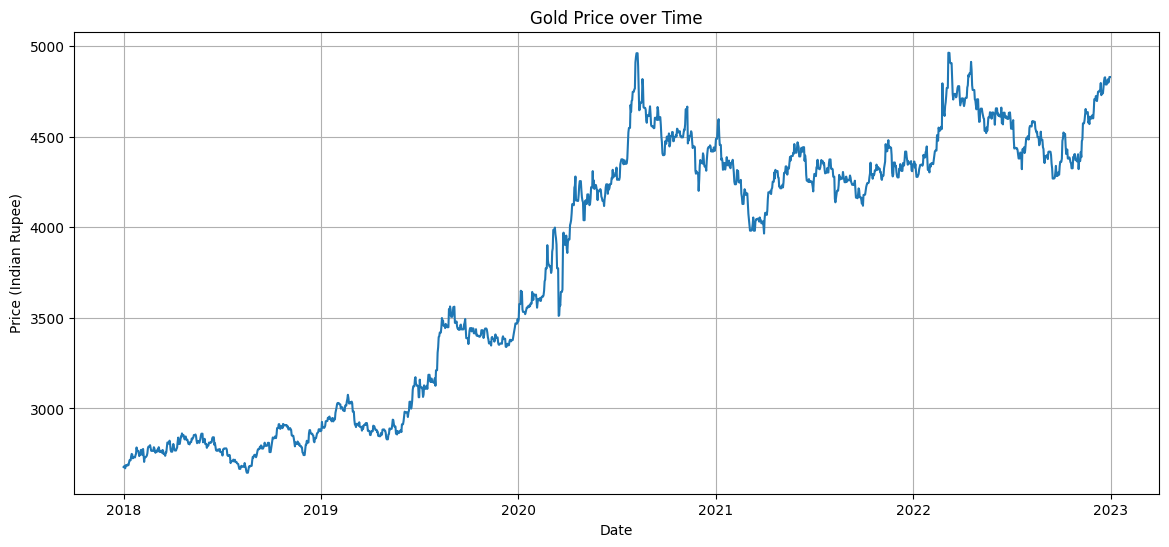

In [15]:
plt.figure(figsize=(14,6))
plt.plot(df_full['Price'])
plt.title('Gold Price over Time')
plt.xlabel('Date')
plt.ylabel('Price (Indian Rupee)')
plt.grid(True)
plt.show()

# 2. Histogram of the gold price to understand the distribution shape (e.g., normal, skewed)

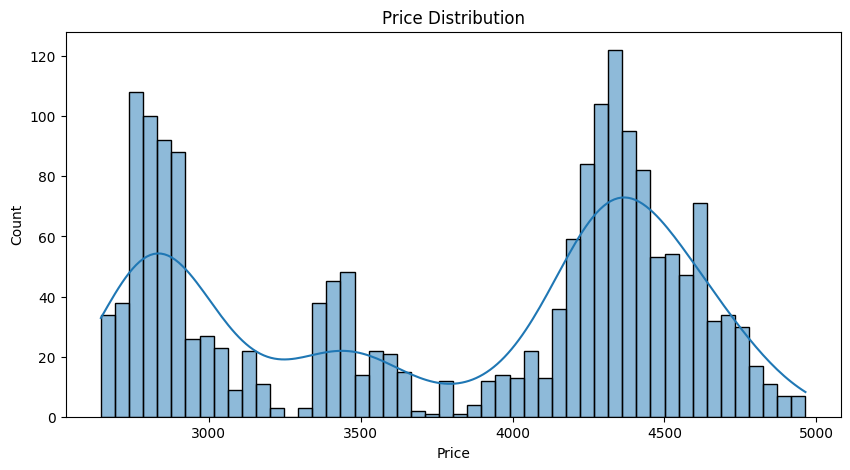

In [16]:
plt.figure(figsize=(10,5))
sns.histplot(df_full['Price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.show()

The histogram shows three distinct peaks (modes), indicating a multimodal distribution. This suggests there may be multiple subgroups or clusters within the data.

The overall distribution is not symmetrical, implying possible skewness and market segmentation.

The data is slightly right-skewed, meaning higher price values are less frequent but still significant.

Overall, the distribution is not normal due to the multiple peaks and uneven spread.


Since the data is skewed, we will be moving forward with non-parametric models

# 3. Boxplot to visualize outliers and the spread of the prices

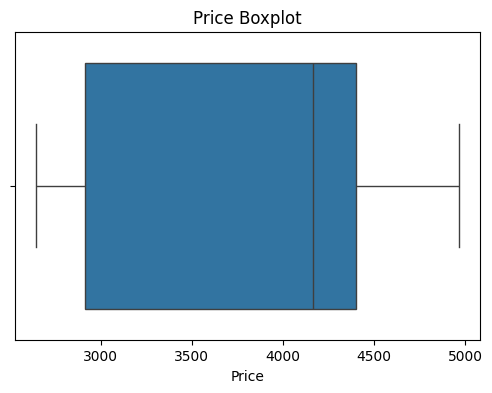

In [17]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_full['Price'])
plt.title("Price Boxplot")
plt.show()

Within the IQR: The distribution leans left-skewed (because the median is closer to Q3).

Overall (considering whiskers and range): The distribution is right-skewed, due to the longer right whisker and higher maximum values.

No significant outliers are present in the dataset.

## 4. Finding Trend and Seasonality in the Time Series Data

In [18]:
# Calculate 30-day rolling mean and standard deviation to observe trend and volatility changes
rolling_mean = df_full['Price'].rolling(window=30).mean()  # Average over past 30 days
rolling_std = df_full['Price'].rolling(window=30).std()    # Std dev over past 30 days

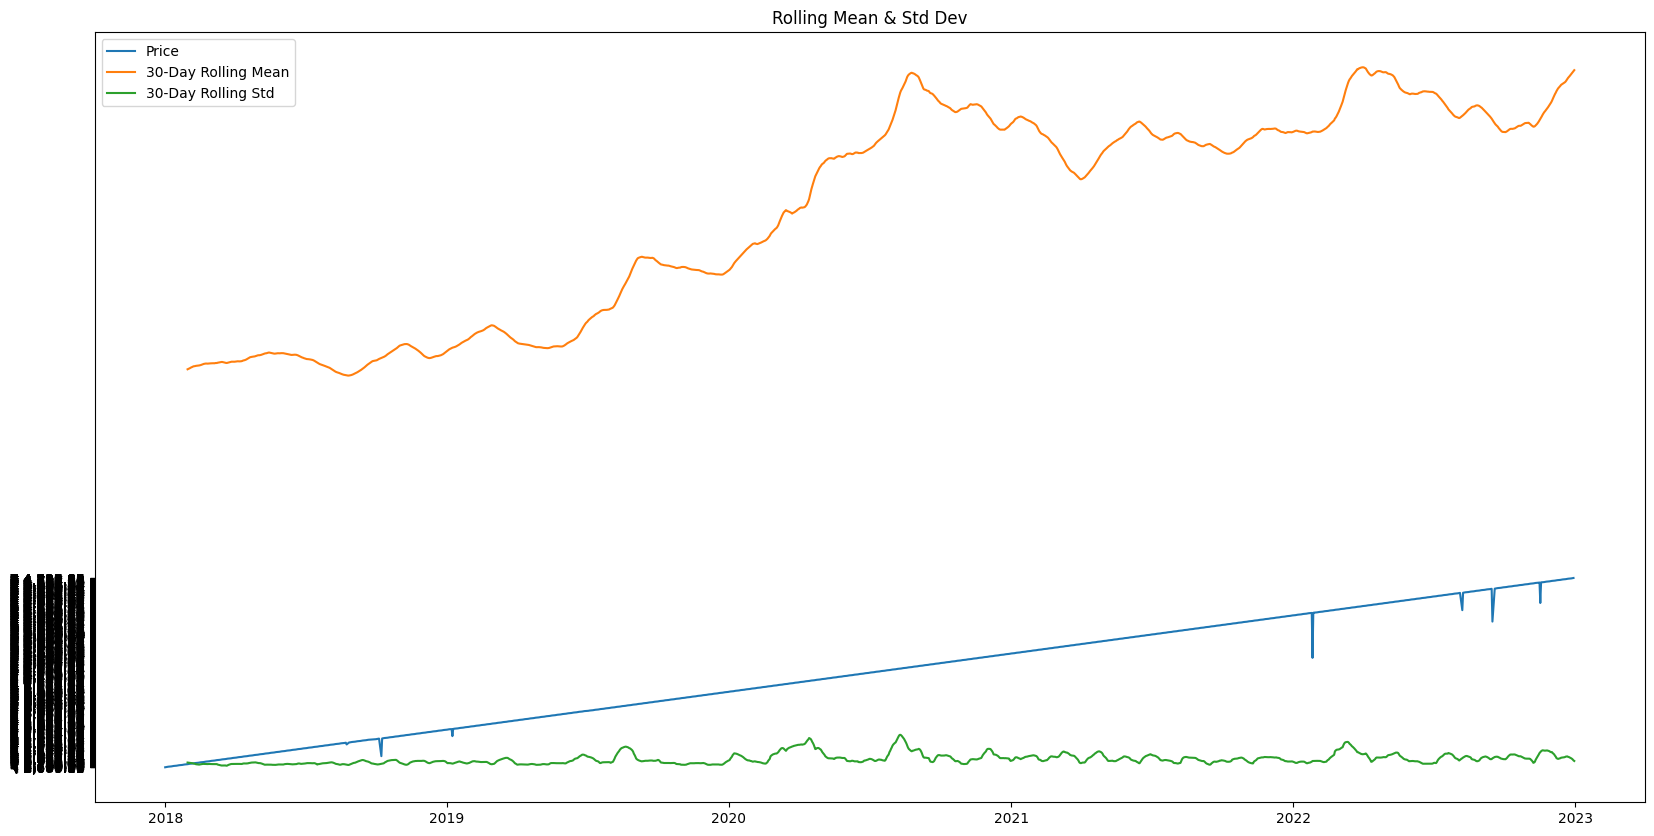

In [19]:
# Plot original price with rolling mean and rolling std dev
plt.figure(figsize=(20,10))
plt.plot(df['Price'], label='Price')
plt.plot(rolling_mean, label='30-Day Rolling Mean')
plt.plot(rolling_std, label='30-Day Rolling Std')
plt.legend()
plt.title('Rolling Mean & Std Dev')
plt.show()

Blue Line (Price):

* Represents the actual price values over time.

* The price appears to generally trend upward over the long term.

* There are some sharp vertical lines—these may indicate missing data, outliers, or sudden spikes/dips.

Orange Line (30-Day Rolling Mean):

* This smooth line shows the average price over the past 30 days, recalculated daily.

* It helps filter out short-term fluctuations to reveal longer-term trends.

* From 2020 onward, you can see a steep upward trend, a peak in 2021, followed by fluctuations, and then another rise toward 2023.

Green Line (30-Day Rolling Std Dev):

* This shows the volatility or variation in the price over the past 30 days.

* Higher peaks in this line suggest periods of more price variability.

* Spikes around 2020 and mid-2022 indicate periods of increased market volatility.

Trend: The price (blue) and its rolling mean (orange) both show a significant upward trend, especially from mid-2019 to early 2021.

Volatility: Noticeable volatility increases during:

Early 2020 (likely due to the COVID-19 market impact),

Mid-2022 (possibly due to economic events or corrections).

By late 2022 into 2023, the price and its rolling mean are at high levels, suggesting a recent upward momentum.

# 5. Feature Engineering

The price data along may not be enough to fit Machine Learning and Deep Learning models as more number of features add more significance to the model. Therefore from the price data, we built few more features. 

The following are the features built

1. Simple Moving Average over 20 days smooths price trend [SMA_20]
2. Exponential Moving Average over 20 days weights recent prices more heavily [EMS_20]
3. Relative Strength Index (RSI) measures momentum over 14 days, helps identify overbought/oversold levels [RSI_14]
4. MACD shows the difference between two EMAs, helps find trend changes [MACD]
5. Bollinger Bands create upper and lower bands around a moving average, capturing volatility [Bollinger High, Bollinger Low]
6. Average True Range (ATR) measures volatility; since we only have price, using price as proxy for high, low, close [ATR]
7. Momentum over 10 days captures the rate of price change [Momentum_10]


In [22]:
old_df=df_full.copy()
old_df = old_df.reset_index()
old_df.to_csv('Preprocessed_Data_with_only price.csv', sep=',', index=False, encoding='utf-8')

In [39]:
import ta  # Technical analysis library

# Simple Moving Average over 20 days smooths price trend
df_full['SMA_20'] = ta.trend.sma_indicator(df_full['Price'], window=20)

# Exponential Moving Average over 20 days weights recent prices more heavily
df_full['EMA_20'] = ta.trend.ema_indicator(df_full['Price'], window=20)

# Relative Strength Index (RSI) measures momentum over 14 days, helps identify overbought/oversold levels
df_full['RSI_14'] = ta.momentum.rsi(df_full['Price'], window=14)

# MACD shows the difference between two EMAs, helps find trend changes
macd = ta.trend.MACD(df_full['Price'])
df_full['MACD'] = macd.macd()  # MACD line
df_full['MACD_signal'] = macd.macd_signal()  # Signal line (EMA of MACD)

# Bollinger Bands create upper and lower bands around a moving average, capturing volatility
bollinger = ta.volatility.BollingerBands(df_full['Price'], window=20, window_dev=2)
df_full['Bollinger_High'] = bollinger.bollinger_hband()  # Upper band
df_full['Bollinger_Low'] = bollinger.bollinger_lband()   # Lower band

# Average True Range (ATR) measures volatility; since we only have price, using price as proxy for high, low, close
df_full['ATR_14'] = ta.volatility.average_true_range(df_full['Price'], df_full['Price'], df_full['Price'], window=14)

# Momentum over 10 days captures the rate of price change
df_full['Momentum_10'] = ta.momentum.roc(df_full['Price'], window=10)

# Drop rows with NaN values due to indicator calculation lag
df_full.dropna(inplace=True)

# Check new features
print(df_full.tail())
print(df_full.shape)


                     Date    Price     SMA_20       EMA_20     RSI_14  \
1821  2022-12-27 00:00:00  4817.06  4772.5255  4765.700433  66.994540   
1822  2022-12-28 00:00:00  4798.47  4776.2215  4768.821344  61.641065   
1823  2022-12-29 00:00:00  4806.80  4779.1260  4772.438359  63.065299   
1824  2022-12-30 00:00:00  4829.89  4783.1850  4777.909944  66.750517   
1825  2022-12-31 00:00:00  4829.89  4787.2440  4782.860425  66.750517   

           MACD  MACD_signal  Bollinger_High  Bollinger_Low     ATR_14  \
1821  40.426805    43.853519     4837.119623    4707.931377  16.465331   
1822  38.280919    42.738999     4837.801145    4714.641855  16.617093   
1823  36.827921    41.556784     4840.720973    4717.531027  16.025158   
1824  37.111779    40.667783     4846.890642    4719.479358  16.529789   
1825  36.911248    39.916476     4851.982499    4722.505501  15.349090   

      Momentum_10  
1821     1.633457  
1822     1.241234  
1823     0.731787  
1824     0.494369  
1825     0.07376

As you can see after removing the null values the size of the data has reduced. Since we need to consider a window not less than 20 to make new features, this data loss is unavoidable.

We will be using this data with new features for our ML and DL model building

Create what you want to predict — price returns or direction — so your model has a supervised learning target.

In [40]:
# Calculate next day percentage return: (Price_t+1 - Price_t) / Price_t
df_full['Return'] = df_full['Price'].pct_change().shift(-1)  # Shifted by -1 so today’s data predicts tomorrow’s return

# Drop the last row which will have NaN target because no next day price
df_full.dropna(inplace=True)

# Create a classification target: 1 if return > 0, else 0
df_full['Direction'] = (df_full['Return'] > 0).astype(int)


In [41]:
df_full = df_full.reset_index()

In [42]:
#Downloading this dataframe with new features as a csv file
df_full.to_csv('Preprocessed_Data_with_features.csv', sep=',', index=False, encoding='utf-8')

In [43]:
df_full.shape

(1792, 14)